# Presentation du projet

## TODO ⌚

# Import de bibliothèques 📚

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport

import os
import re

from math import log2, sqrt
import numpy as np
import scipy.stats as stats
from scipy.stats import gaussian_kde, t, ttest_1samp, ttest_ind
from statsmodels.stats.proportion import proportion_confint


import matplotlib.pyplot as plt
import seaborn

# Fonctions ⚙️

In [2]:
def plot_histo(data, title=None, xlabel=None, drop_outliers=False, bins='sturges', plot_density=True):
    if drop_outliers:
        data = data[data.between(data.quantile(drop_outliers), data.quantile(1 - drop_outliers))]
    if bins == 'sturges':
        bins = int(1+log2(len(data)))
#     mu = data.mean()
#     sigma = data.std()
#     x_norm = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#     plt.plot(x_norm, stats.norm.pdf(x_norm, mu, sigma), label="Gaussienne de l'échantillon")
    plt.style.use("seaborn")
    if plot_density:
        density = gaussian_kde(data)
        xs = np.linspace(data.min(),data.max(),200)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        plt.plot(xs,density(xs), label="Courbe de densité")
    plt.ylabel("frequency")
    plt.xlabel(xlabel)
    plt.title(title)
    plt.hist(data, bins=bins, density=True)
    plt.legend()
    plt.show()

In [3]:
def split_custom(label_string, delimiter=','):
    """Cette fonction prend en argument une chaine de caractères et retourne une liste"""
    return label_string.split(delimiter)

In [4]:
def get_unique_elements(panda_serie):
    """This functions returns the list of unique elements 
    out of a panda serie of strings with comma separated elements"""
    all_labels = set()
    for labels in panda_serie.map(split_custom):
        for label in labels:
            all_labels.add(label)
    return list(all_labels)

<a id='fonctionbio'></a>

In [5]:
def test_bio(labels):
    """From a list of labels this function returns a booleean if 'organic' or 'bio' is in one of the labels"""
    bool_test = False
    for label in labels:
        label = label.lower()
        if 'organic' in label or 'bio' in label:
            bool_test = True
            break
    return bool_test

Retour au [script](#backbio)

<a id='fonctionvege'></a>

In [6]:
def test_vege(labels):
    """From a list of labels this function returns a booleean if 'organic' or 'bio' is in one of the labels"""
    bool_test = False
    for label in labels:
        label = label.lower()
        if 'vegetarian' in label or 'vegan' in label:
            bool_test = True
            break
    return bool_test

Retour au [script](#backvege)

<a id='fonctionnegation'></a>

In [7]:
# # This function works but would be more efficient if it would detect the language. We'll save that for later
def test_no_something(labels, dict_something):
    """From a list of labels this function returns a booleean if 'preserative' and a negation is in one of the labels"""
    for word, negations in dict_something.items():
        for label in labels:
            label = label.lower()
            label = label.replace('-', ' ')
            bool_list = []
            #looking for word preservative
            preservative_in_label = bool(re.match(r'.*\b{}.*\b'.format(word), label))
            if preservative_in_label:
                #looking for negation
                for negation in negations:
                    if bool(re.match(r'.*\b{}\b'.format(negation), label)):
                        return True

    return False

- Retour au [script](#backconserv) Conservateurs
- Retour au [script](#backcolor) Colorants
- Retour au [script](#backGMO) OGMs

<a id='plot_bar'></a>

In [8]:
def plot_bar(data, labels, color='purple', label=None, rotation=False):
    plt.figure(figsize=(8,8))
    plt.style.use('seaborn')
    plt.bar(list(range(1, len(data)+1)), data, color=color, label=label)
    if rotation:
        angle=90
    else:
        angle=0
    plt.xticks(list(range(1, len(data)+1)), labels, rotation=angle, fontsize=12)
    plt.ylabel('Proportion par rapport au nombre de poduits du dataset (%)')
    plt.legend()
    plt.show()

- Retour au [script](#univ_1_plot_1) Labels
- Retour au [script](#univ_1_plot_2) Categories

# Données 🎁

In [9]:
data = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep='\t')

/Users/hugorebeix/opt/anaconda3/envs/env_OC_p03/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,12,26,27,28,30,51,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
data.shape

(1524579, 183)

In [11]:
data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=183)

# Profiling 🔍

Etant données les dimensions de ce dataset, je vais réaliser l'analyse préliminaire avec Pandas Profiling. L'analyse est exportée en HTML pour une meilleure lisibilité du NB

In [12]:
# profile = ProfileReport(data, title="Report on OpenFoodFacts", minimal=True)

In [13]:
# profile.to_file('profile_report.html')

Voir le report : [cliquer ici](profile_report.html)

# Idee : 💡
### A partir d'un produit, proposer des produits similaires ayant un emballage meilleur. Appuyer l'analyse par des etudes sur le lien entre l'emballage plastique et les mauvaises caractéristiques nutritionnelles.
## Mieux manger serait-il lié à l'emballage?

Afin de vérifier la faisibilité de cette étude, nous allons déterminer les features necessaires, filtrer les NAN et regarder la taille du dataset filtré

In [14]:
col_necessaires = ['labels_en', 'saturated-fat_100g', 'categories_en', 
                   'packaging_tags', 'additives_n', 'ingredients_from_palm_oil_n', 
                   'nutriscore_score', 'nutriscore_grade', 'pnns_groups_2']
# TODO : REMPLACER CATEGORIES PAR pnns-goups

In [15]:
data_filtre = data.dropna(subset=col_necessaires)

In [16]:
data_filtre.shape

(92328, 183)

Cette quantité a l'air suffisante à première vue

# Nettoyage 🧼

Les colonnes suivantes necessitent une attention particulière du fait de leur forte cardinalité:
- [Labels](#nett_1)
- [Categories](#nett_2)
- [Packaging](#nett_3)

<a id='nett_1'></a>
### Labels 🏷️

In [17]:
data_filtre.labels_en.describe()

count         92328
unique        31719
top       Green Dot
freq           5153
Name: labels_en, dtype: object

Cette variable a une forte cardinalité et est qualitative. Regardons les instances les plus fréquentes

In [18]:
data_filtre.labels_en.value_counts().head(10)

Green Dot                                       5153
Made in France                                  2218
Gluten-free                                     1605
Vegetarian,Vegan                                1513
Organic,EU Organic,AB Agriculture Biologique    1277
Organic                                         1189
No preservatives                                1171
Green Dot,Made in France                         782
Made in Germany                                  702
Vegetarian                                       697
Name: labels_en, dtype: int64

On voit que les données sont souvent séparées par des virgules et que beaucoup de labels se répétent

In [19]:
labels_unique = get_unique_elements(data_filtre.labels_en)
len(labels_unique)

9611

Grâce à ce traitement, on obtient la cardinalité réelle mais c'est toujours trop

Dans l'idéal, pour cette étude, j'aimerais pouvoir séparer les labels avec ces grandes catégories suivantes:

In [20]:
labels_simple = ['organic', 'vegetarian_or_vegan', 'no_preservatives', 'no_colorings', 'sustainable', 'no_gmos', 'no_artificial_flavors']

Je vais partir sur une approche "Dummy" pour faciliter les filtrages. En effet je ne peux résumer un produit à un seul label.

<a id='backbio'></a>

Gestion du Bio (accès à la fonction [ici](#fonctionbio))

In [21]:
data_filtre.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=183)

In [22]:
data_filtre['is_labeled_organic'] = data_filtre['labels_en'].map(split_custom).map(test_bio)

<ipython-input-22-1c4cc4edf2d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_organic'] = data_filtre['labels_en'].map(split_custom).map(test_bio)


<a id='backvege'></a>

Gestion du Végétarien (accès à la fonction [ici](#fonctionvege))

In [23]:
data_filtre['is_labeled_vege_or_vegan'] = data_filtre.labels_en.map(split_custom).map(test_vege)

<ipython-input-23-1be3452212da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_vege_or_vegan'] = data_filtre.labels_en.map(split_custom).map(test_vege)


<a id='backconserv'></a>

Gestion des conservateurs (accès à la fonction [ici](#fonctionnegation))

In [24]:
preserv = []
for label in labels_unique:
    label = label.lower()
    if 'konser' in label:
        preserv.append(label)

In [25]:
# preserv

In [26]:
negations_english = ["no", "free", "without", '0', 'non']
negations_french = ["pas", "sans", "0", "aucun"]
negations_spanish= ['no', 'sin', 'zero', '0', 'libre', 'cero']
negations_portuguese = ['sem', 'nao']
negations_germanique = ['nie', 'bez', 'ohne', 'frei', 'utan', 'brez', 'keine']
dict_conservateur = {"conservateur": negations_french, "preservative": negations_english, 
                     'conservante':negations_spanish + negations_portuguese, 'konser': negations_germanique}

In [27]:
data_filtre['is_labeled_preserv_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_conservateur)

<ipython-input-27-7ecc0dafc191>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_preserv_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_conservateur)


In [28]:
data_filtre['is_labeled_preserv_free'].value_counts()

False    82840
True      9488
Name: is_labeled_preserv_free, dtype: int64

<a id='backcolor'></a>

Gestion des Colorants (accès à la fonction [ici](#fonctionnegation))

In [29]:
color = []
for label in labels_unique:
    label = label.lower()
    if 'color' in label:
        color.append(label)

In [30]:
# color

In [31]:
dict_colorant = {"color": negations_french + negations_english + negations_spanish, "corante":negations_portuguese, 'farb': negations_germanique}

In [32]:
data_filtre['is_labeled_colorings_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_colorant)

<ipython-input-32-e97131e051d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_colorings_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_colorant)


In [33]:
data_filtre['is_labeled_colorings_free'].value_counts()

False    85018
True      7310
Name: is_labeled_colorings_free, dtype: int64

<a id='backGMO'></a>

Gestion des OGMs (accès à la fonction [ici](#fonctionnegation))

In [34]:
ogm = []
for label in labels_unique:
    label = label.lower()
    if 'gmo' in label:
        ogm.append(label)

In [35]:
# ogm

In [36]:
dict_ogm = {"ogm": negations_french + negations_portuguese, 'gmo': negations_english + negations_portuguese, 'gvo': negations_germanique}

In [37]:
data_filtre['is_labeled_gmos_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_ogm)
# data_filtre['is_labeled_gmos_free'] = data_filtre.labels_en.map(split_custom).apply(lambda x : test_no_something(x, dict_ogm), axis=1) #essayer 

<ipython-input-37-af83a8e75941>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_gmos_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_ogm)


In [38]:
data_filtre['is_labeled_gmos_free'].value_counts()

False    90171
True      2157
Name: is_labeled_gmos_free, dtype: int64

<a id='nett_2'></a>
### Categories 🗂️

Je pensais d'abord utiliser les données categories_n. mais la données pnns_groups_2 est déjà travaillée et est renseignée à presque 100%

In [39]:
data_filtre['pnns_groups_2'].value_counts(normalize=True).head(8)

Biscuits and cakes    0.089009
One-dish meals        0.085565
unknown               0.082099
Sweets                0.056213
Processed meat        0.055162
Cereals               0.054707
Milk and yogurt       0.052335
Cheese                0.050700
Name: pnns_groups_2, dtype: float64

In [40]:
data_filtre.loc[:,'pnns_groups_2'] = data_filtre.loc[:,'pnns_groups_2'].map(lambda x:x.lower()) #Inplace = true

/Users/hugorebeix/opt/anaconda3/envs/env_OC_p03/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [41]:
data_filtre = data_filtre.replace('pizza pies and quiche', 'pizza pies and quiches')

TODO : Faire un KNN sur les données "Unknown" : 8.2% des données

<a id='nett_3'></a>
### Packaging 📦
Cette donnée essentielle à notre étude necessite un gros travail de traitement

In [42]:
data_filtre.packaging_tags.describe()

count                92328
unique               18443
top       sachet,plastique
freq                  4878
Name: packaging_tags, dtype: object

Même configuration : forte cardinalité d'une variable qualitative

In [43]:
data_filtre.packaging_tags.value_counts().head(50)

sachet,plastique               4878
plastique                      2626
kunststoff                     2017
carton                         1963
frais,plastique                1611
barquette,plastique            1460
frais                          1454
carton,plastique               1224
plastic                        1189
sachet                         1155
bouteille,plastique            1082
glas                           1077
bocal,verre                    1024
sachet-plastique                910
conserve                        804
plastico                        630
brique,carton                   614
bouteille,verre                 597
carton,boite,plastique          559
karton                          544
sachet,plastique,surgele        523
bocal,verre,couvercle,metal     518
barquette                       492
papier                          486
conserve,metal                  481
barquette,plastique,frais       477
brique                          464
bocal,verre,metal           

Dans un premier temps je me limiterai à une analyse binaire Plastique/Pas de plastique

En regardant les produits dont le packaging tag est "sachet", je vois qu'ils sont en plastique

In [44]:
data_filtre[data_filtre['packaging_tags'] == 'sachet'][['product_name', 'url']].sample(1).iloc[0,1]

'http://world-en.openfoodfacts.org/product/3257981685697/nature-bio-raisins-secs-sultanines-bio'

In [45]:
plastic_test = lambda x : bool(re.search(r'plast', x)) or bool(re.search(r'kunstoff', x)) or bool(re.search(r'sachet',x))
data_filtre["has_plastic"] = data_filtre['packaging_tags'].map(plastic_test)

Voir l'[analyse univariée du critère plastique](#univ_3)

# Analyses Univariées 📊
##### - [Labels](#univ_1)
##### - [Categories](#univ_2)
##### - [Packaging](#univ_3)
##### - [Additifs](#univ_4)
##### - [Huile de palme](#univ_5)
##### - [Graisse saturée](#univ_6)
##### - [Nutriscore numérique](#univ_7)
##### - [Nutriscore catégorique](#univ_8)

<a id='univ_1'></a>
### Labels 🏷️

Les labels nous donne des informations sur le type d'aliment et surtout sur le soin apporté par l'industriel pour le produit.
L'analyse en histogramme nous permet ici d'y voir plus clair sur la quantité de labels dans le dataset mais ne nous permet pas de réaliser de véritables analyses univariée.
Il serait interessant de mener des analyse univariées d'un autre paramètre sur un classe de labels

In [46]:
labels_to_inspect = ['is_labeled_organic',
                     'is_labeled_vege_or_vegan',
                     'is_labeled_preserv_free',
                     'is_labeled_colorings_free',
                     'is_labeled_gmos_free']

qtty_label = [data_filtre[label_to_inspect].value_counts().loc[True] for label_to_inspect in labels_to_inspect]
percent_label = np.array(qtty_label)/len(data_filtre) * 100

<a id='univ_1_plot_1'></a>

Voir fonction [ici](#plot_bar)

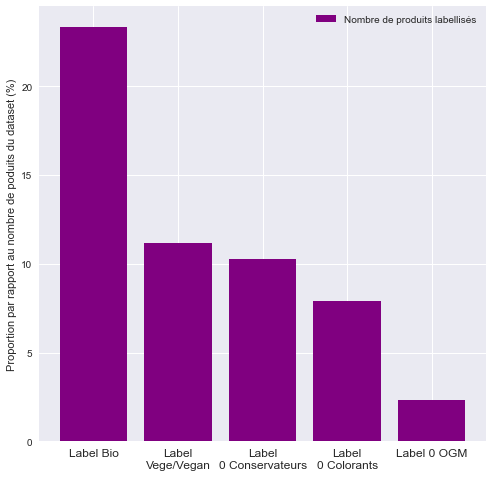

In [47]:
plot_bar(percent_label, ['Label Bio', 'Label\nVege/Vegan', 'Label\n0 Conservateurs', 'Label\n0 Colorants', 'Label 0 OGM'], label='Nombre de produits labellisés')

<a id='univ_2'></a>
### Categories 🗂️

In [48]:
data_filtre.pnns_groups_2.describe()

count                  92328
unique                    40
top       biscuits and cakes
freq                    8218
Name: pnns_groups_2, dtype: object

Les catégories de pnns_groups_2 sont bien mieux référencées que celles des categories_en

In [49]:
data_filtre.pnns_groups_2.value_counts().head(10)

biscuits and cakes      8218
one-dish meals          7900
unknown                 7580
sweets                  5190
processed meat          5093
cereals                 5062
milk and yogurt         4832
cheese                  4681
dressings and sauces    3686
vegetables              3316
Name: pnns_groups_2, dtype: int64

Voir la fonction [ici](#plot_bar)

<a id='univ_1_plot_2'></a>

In [50]:
data_bar_categ = data_filtre.pnns_groups_2.value_counts()/len(data_filtre) *100
labels = list(data_filtre.pnns_groups_2.value_counts().index)

In [51]:
len(labels)

40

No handles with labels found to put in legend.


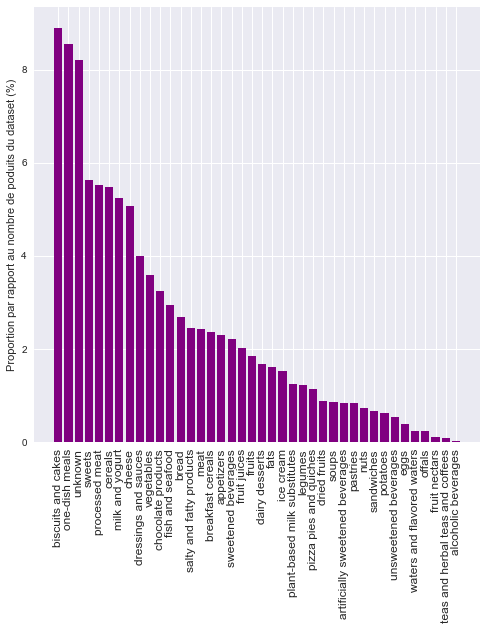

In [52]:
plot_bar(data_bar_categ, labels, rotation=True)

Dans le cadre du projet d'application, cette colonne nous servira a proposer un produit de la même catégorie. Il faudra également la rassembler en moins de cardinalités

On peut aussi se servir de cette colonne pour un analyse spécifique d'une catégorie d'aliments. par exemple pour voir si le nutriscore est meilleur sans plastique pour certaines catégories.

<a id='univ_3'></a>
### Packaging

In [53]:
data_filtre.packaging_tags.describe()

count                92328
unique               18443
top       sachet,plastique
freq                  4878
Name: packaging_tags, dtype: object

In [54]:
data_filtre.packaging_tags.value_counts().head(10)

sachet,plastique       4878
plastique              2626
kunststoff             2017
carton                 1963
frais,plastique        1611
barquette,plastique    1460
frais                  1454
carton,plastique       1224
plastic                1189
sachet                 1155
Name: packaging_tags, dtype: int64

Pour l'analyse univariée nous nous contenterons pour le moment d'analyser la variable binaire "has_plastic" calculée dans la partie [nettoyage](#nett_3)

In [55]:
data_filtre['has_plastic'].value_counts()

True     49390
False    42938
Name: has_plastic, dtype: int64

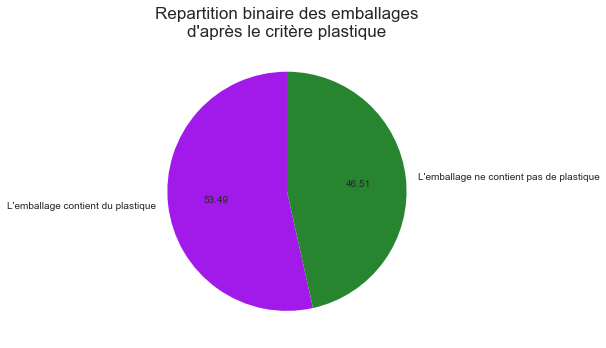

In [56]:
plt.title("Repartition binaire des emballages\nd'après le critère plastique", fontsize=17)
plt.pie(data_filtre['has_plastic'].value_counts(), labels=["L'emballage contient du plastique", "L'emballage ne contient pas de plastique"], 
        colors=['#A21AEA', '#278530'], autopct='%.2f', startangle=90)
plt.show()

Une majorité de produits sont emballés en partie ou totalement dans du plastique

#### Intervalle de confiance sur cette repartition:

In [57]:
data_filtre['has_plastic'].value_counts().loc[False]

42938

In [58]:
n_produits_total = len(data_filtre)
n_produits_sans_plastique = data_filtre['has_plastic'].value_counts().loc[False]
proportion_estim = n_produits_sans_plastique / n_produits_total

In [59]:
proportion_estim

0.46505935360887274

Niveau de confiance

In [60]:
alpha = 0.05
interv_conf_propor_pduits_sans_plastique = proportion_confint(n_produits_sans_plastique, n_produits_total, alpha=alpha, method='normal')
interv_conf_propor_pduits_sans_plastique

(0.4618420772485127, 0.4682766299692328)

<a id='univ_4'></a>
### Additifs

In [61]:
data_filtre.additives_n.describe()

count    92328.000000
mean         1.575221
std          2.239675
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         30.000000
Name: additives_n, dtype: float64

In [62]:
data_filtre.additives_n.head(5)

323    2.0
346    4.0
384    0.0
385    1.0
393    3.0
Name: additives_n, dtype: float64

Cette variable est une variable quantitative visiblement entière

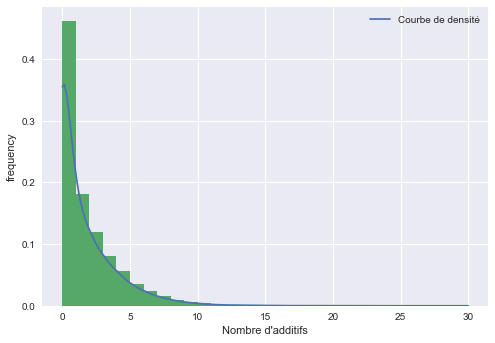

In [63]:
plot_histo(data_filtre.additives_n, bins=30, xlabel="Nombre d'additifs")

J'aimerais utiliser cette variable pour tester la correlation entre le nombre d'additifs et la présence de plastique dans l'emballage

<a id='univ_5'></a>
### Huile de palme

In [64]:
data_filtre.ingredients_from_palm_oil_n.describe()

count    92328.000000
mean         0.037984
std          0.193748
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: ingredients_from_palm_oil_n, dtype: float64

In [65]:
data_filtre.ingredients_from_palm_oil_n.value_counts()

0.0    88867
1.0     3415
2.0       46
Name: ingredients_from_palm_oil_n, dtype: int64

<a id='univ_6'></a>
### Graisse saturée

In [66]:
data_filtre['saturated-fat_100g'].describe()

count    92328.000000
mean         5.480784
std          8.357085
min          0.000000
25%          0.350000
50%          2.000000
75%          7.700000
max        140.000000
Name: saturated-fat_100g, dtype: float64

Cette variable quantitative donne le nombre de grammes de graisse saturée pour 100g de produit. Il n'est donc pas logique que certains produits aient une valeur de plus de 100.
Regardons ces valeurs

In [67]:
data_filtre[data_filtre['saturated-fat_100g'] >= 100][['product_name', 'nutriscore_grade', 'quantity', 'saturated-fat_100g', 'serving_size', 'ingredients_text']]

,product_name,nutriscore_grade,quantity,saturated-fat_100g,serving_size,ingredients_text
652577,Palets dorés noix de coco,e,125 g,120.0,23 g,"Farine de ble 50%, sucre, noix de coco 8,4%, h..."
915679,Virgin coconuts oil,d,380 ml,100.0,NaN,Noix de coco bio.
1212389,Kokosöl BIO,e,182g,100.0,NaN,Bio Kokosfett (Sri Lanka). Kokosfett: Fairtrad...
1353590,Aceite de oliva virgen extra &quot;Esencia And...,c,10 ml,140.0,10 ml,Aceite de oliva virgen extra.


Bien que surprenant à première vue, ces outliers n'en sont peut etre pas étant donné que ce sont en fait des huiles liquides. Je suspecte que la données saturated fat soit ici une donnée en ml et que le taux de passage ml-g soit approximatif.
Seul le premier semble suspect d'autent qu'il possède 50% de farine. Je vais donc le supprimer

In [68]:
data_filtre = data_filtre.drop([652577])

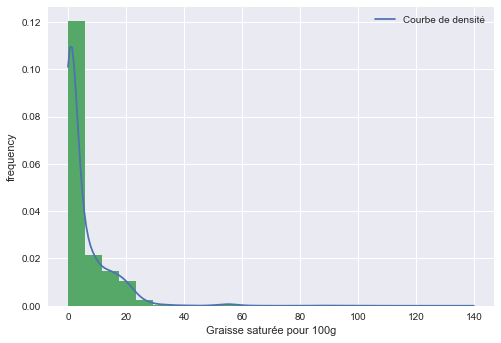

In [69]:
plot_histo(data_filtre['saturated-fat_100g'], bins=24, xlabel="Graisse saturée pour 100g")

<a id='univ_7'></a>
### Nutriscore (numérique)

In [70]:
data_filtre.nutriscore_score.describe()

count    92327.000000
mean         8.115438
std          9.061855
min        -15.000000
25%          1.000000
50%          7.000000
75%         15.000000
max         36.000000
Name: nutriscore_score, dtype: float64

C'est une variable quantitative sur la qualité des aliments

Voici la documentation:

<img src="img/nutriscore.png" style="height:250px">

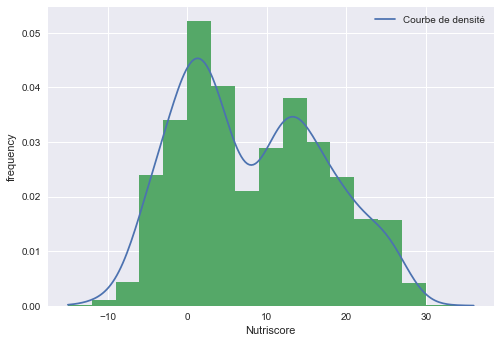

In [71]:
plot_histo(data_filtre['nutriscore_score'], xlabel="Nutriscore")

Mesure de la symetrie avec Skewness : 

In [72]:
data_filtre.nutriscore_score.skew()

0.26514023697425426

On voit que la distribution est quasi symétrique avec un léger décalage à gauche

<a id='univ_8'></a>
### Nutriscore (grade)

In [73]:
data_filtre.nutriscore_grade.describe()

count     92327
unique        5
top           d
freq      24722
Name: nutriscore_grade, dtype: object

In [74]:
data_filtre.nutriscore_grade.unique()

array(['b', 'e', 'd', 'c', 'a'], dtype=object)

In [75]:
data_filtre.nutriscore_grade.value_counts()

d    24722
c    20149
a    17401
e    15942
b    14113
Name: nutriscore_grade, dtype: int64

Cette note connue du grand public est une note de A à E (A étant la meilleure et E la moins bonne). C'est donc une variable qualitative ordonnée. On peut la traiter comme une variable quantitative

In [76]:
data_filtre['nutriscore_grade_num'] = data_filtre.nutriscore_grade.replace({'a':4, 'b':3, 'c':2, 'd':1, 'e':0})

In [77]:
data_pie_nutriscore = data_filtre['nutriscore_grade_num'].value_counts().sort_index()

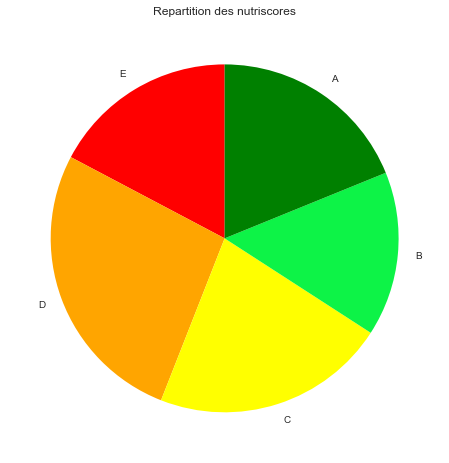

In [78]:
plt.figure(figsize=(8,8))
plt.style.use('seaborn')
plt.title("Repartition des nutriscores")
plt.pie(data_pie_nutriscore, labels=['E', 'D', 'C', 'B', 'A'], colors=['red','orange','yellow', '#0DF347', 'green'], startangle=90)
plt.show()

No handles with labels found to put in legend.


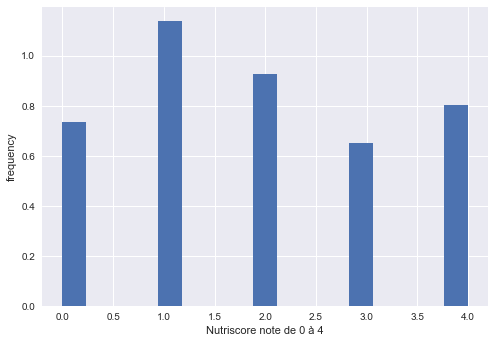

In [79]:
plot_histo(data_filtre['nutriscore_grade_num'], plot_density=False, xlabel='Nutriscore note de 0 à 4')

In [80]:
data_filtre['nutriscore_grade_num'].describe()

count    92327.000000
mean         1.916698
std          1.363183
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: nutriscore_grade_num, dtype: float64

In [81]:
data_filtre['nutriscore_grade_num'].skew()

0.18810225317894622

In [82]:
data_filtre['nutriscore_grade_num'].kurtosis()

-1.1812695990028848

La repartition n'est pas uniforme mais fera quand mêmel'approximation qu'elle l'est au regard de l'écart interquartile, de kurtosis et de skewness

## 1: Analyse bivariée entre le type d'emaballage et le nutriscore_score

In [83]:
X = "has_plastic" # qualitative
Y = "nutriscore_score" # quantitative

In [84]:
echantillon_1 = data_filtre[['nutriscore_score', 'has_plastic']]

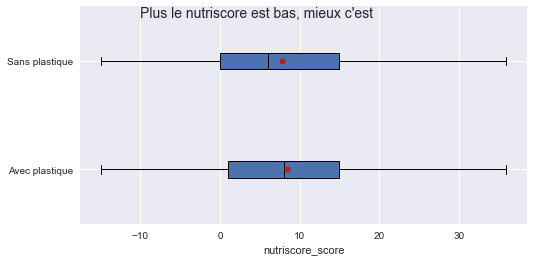

In [85]:
modalites = [True, False]
groupes = []
for m in modalites:
    groupes.append(echantillon_1[echantillon_1[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(8,4))
plt.style.use('seaborn')
plt.boxplot(groupes, labels=['Avec plastique', 'Sans plastique'], showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.text(-10,2.4, "Plus le nutriscore est bas, mieux c'est", fontsize=14)
plt.xlabel(Y)
plt.show()

On voit que la moyenne et la mediane sont plus faibles (donc meilleures) pour les produits sans plastiques

In [86]:
X = "has_plastic" # qualitative
Y = "nutriscore_grade_num" # quantitative
echantillon_2 = data_filtre[[Y, X]]

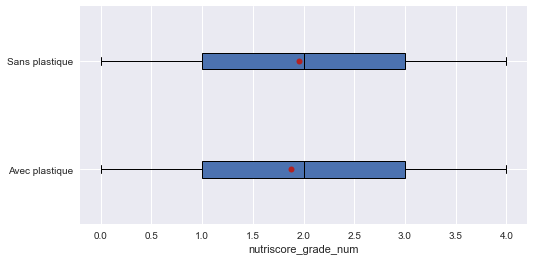

In [87]:
modalites = [True, False]
groupes = []
for m in modalites:
    groupes.append(echantillon_2[echantillon_2[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(8,4))
plt.style.use('seaborn')
plt.boxplot(groupes, labels=['Avec plastique', 'Sans plastique'], showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel(Y)
plt.show()

Sur ce graphe on voit que la repartition du nutriscore (grade) est similaire pour les deux classes. On remarque par contre que la moyenne est inférieure pour les produits emballés dans du plastique

## 2: Analyse bivariée entre le type d'emballage et le nutriscore_grade

### Avec seulement deux catégories plastique/pas de plastique

Tableau de contingence

In [88]:
data_filtre.has_plastic.value_counts()

True     49389
False    42938
Name: has_plastic, dtype: int64

In [89]:
X = "nutriscore_grade"
Y = "has_plastic"

echantillon_3 = data_filtre[['nutriscore_grade', 'has_plastic']]
cont = echantillon_3[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len ,margins=True,margins_name="Total")

In [90]:
cont['Freq_False'] = cont.loc[:,0] / cont.Total * 100

In [91]:
cont

has_plastic,False,True,Total,Freq_False
nutriscore_grade,,,,
a,8153,9248,17401,46.853629
b,7235,6878,14113,51.264791
c,9595,10554,20149,47.620229
d,10561,14161,24722,42.719036
e,7394,8548,15942,46.380630
Total,42938,49389,92327,46.506439


### Analyse statistique:
Obtention de l'intervalle de confiance de la proportion de produits sans plastique dans la population Nutriscore Grade = A ou B

In [92]:
echantillon_4 = data_filtre[data_filtre['nutriscore_grade'].isin(['a', 'b'])][['nutriscore_grade', 'has_plastic']].replace({True:0, False:1}).rename(columns={'has_plastic': 'no_plastic'})

In [93]:
echantillon_4.head(5)

,nutriscore_grade,no_plastic
323,b,0
346,b,0
406,b,0
906,a,1
911,a,1


In [94]:
n_produits_sains = len(echantillon_4)
n_produits_sains_sans_platique = echantillon_4.no_plastic.sum()
proportion_estim = n_produits_sains_sans_platique / n_produits_sains

In [95]:
proportion_estim

0.4882909183220156

Niveau de confiance

In [96]:
from statsmodels.stats.proportion import proportion_confint

In [97]:
alpha = 0.05
proportion_confint(n_produits_sains_sans_platique, n_produits_sains, alpha=alpha, method='normal')

(0.48277208584243037, 0.49380975080160083)

On peut ici affirmer que le taux d'aliments sans plastique dans la population d'aliments "sains" (c-à-d des groupes A et B) est supérieur au taux général d'aliment sans plastique sur l'ensemble de la population dont l'intervalle de confiance est rappelé ci dessous.  cf [Analyse univariée de la variable "has_plastic"](#univ_3)

In [98]:
interv_conf_propor_pduits_sans_plastique

(0.4618420772485127, 0.4682766299692328)

### Tests statistiques

Objectif : Montrer statistiquement que la moyenne des nutriscores (grades) des produits sans plastique est supérieure à celle des produits ayant du plastique.

Pour cela je vais d'abord estimer la moyenne des nutriscores des aliments avec plastique sous forme d'intervalle de confiance et prendre le "pire" cas. C'est à dire la borne supérieure de cet IC
Je menerai ensuite un test statistique sur la moyenne des nutriscore des produits sans plastique.

In [99]:
moy_empirique_plastique = data_filtre[data_filtre['has_plastic']]['nutriscore_grade_num'].mean()
sigma_empirique_plastique = data_filtre[data_filtre['has_plastic']]['nutriscore_grade_num'].std()
n_echantillon_plastique = len(data_filtre[data_filtre['has_plastic']])

In [100]:
alpha = 0.05
ic_sup_moy_nutriscore_plast = moy_empirique_plastique + t.ppf(1 - alpha / 2 , n_echantillon_plastique - 1)*sigma_empirique_plastique/sqrt(n_echantillon_plastique)
ic_sup_moy_nutriscore_plast

1.8928903490402877

In [101]:
moy_empirique_plastique

1.8808844074591509

In [123]:
sigma_empirique_plastique

1.3612961233766934

On teste : 
- H0 : μ = ic_sup_moy_nutriscore_plast (les produits plastiques ont la même moyenne de nutriscore que les produits sans plastiques)
- H1 : μ > ic_sup_moy_nutriscore_plast (les produits sans plastique ont un nutriscore moyen supérieur au produits emballés dans du plastique)

In [102]:
test_IC = ttest_1samp(data_filtre[data_filtre['has_plastic'] == False]['nutriscore_grade_num'],ic_sup_moy_nutriscore_plast)

In [103]:
test_IC.pvalue

5.737869669356307e-23

Ce test est "two sided". il faut donc diviser la p-value par 2

In [104]:
p_value_test_ic = test_IC.pvalue / 2

In [105]:
p_value_test_ic

2.8689348346781536e-23

On peut rejeter l'hypothèse H0

On teste : 
- H0 : μ_no_plast <= μ_plast (les produits sans plastiques ont une moyenne de nutriscore inférieure ou égale à celle des produits emballés dans du plastique)
- H1 : μ_no_plast > μ_plast (les produits sans plastiques ont une moyenne de nutriscore supérieure à celle des produits emballés dans du plastique)

In [106]:
data_filtre[data_filtre['has_plastic'] == False]['nutriscore_grade_num'].mean()

1.9578927756299782

In [107]:
data_filtre[data_filtre['has_plastic']]['nutriscore_grade_num'].mean()

1.8808844074591509

In [108]:
test_bi_variable = ttest_ind(data_filtre[data_filtre['has_plastic'] == False]['nutriscore_grade_num'],
                             data_filtre[data_filtre['has_plastic']]['nutriscore_grade_num'])

In [109]:
test_bi_variable.pvalue

1.0973634431044843e-17

Ce test est "two sided". il faut donc diviser la p-value par 2

In [110]:
p_value_test_bi_variable = test_bi_variable.pvalue / 2

In [111]:
p_value_test_bi_variable

5.4868172155224216e-18

On peut egalement rejeter l'hypothèse H0

Regardons si on peut affirmer cette hypothèse pour toute les catégories

In [118]:
p_values_categs = {}
size_categs = {}
for categ in data_filtre.pnns_groups_2.unique():
    data_categ = data_filtre[data_filtre['pnns_groups_2'] == categ]
    size_categs[categ] = len(data_categ)
    p_values_categs[categ] = ttest_ind(data_categ[data_categ['has_plastic'] == False]['nutriscore_grade_num'],
                                       data_categ[data_categ['has_plastic']]['nutriscore_grade_num']).pvalue/2

In [119]:
p_values_categs = pd.Series(p_values_categs)
size_categs = pd.Series(size_categs)

In [120]:
df_p_values_categs = pd.DataFrame({'p_values' : p_values_categs.values, 'size_echantillon' : size_categs.values}, index=p_values_categs.index)

In [121]:
df_p_values_categs.sort_values(by=['p_values'], ascending=False, inplace=True)

Catégories pour lesquelles on ne peux pas rejetter H0:

In [122]:
df_p_values_categs[df_p_values_categs['p_values'] > 0.05]

,p_values,size_echantillon
unknown,0.497316,7580
fruits,0.483708,1711
legumes,0.473002,1125
eggs,0.435132,348
salty and fatty products,0.427126,2252
artificially sweetened beverages,0.404987,764
plant-based milk substitutes,0.357124,1137
pastries,0.342487,760
alcoholic beverages,0.322688,10
offals,0.321990,213


Regardes la variance , moyenne, std pour les fruits oeufs et legumes

In [125]:
df_p_values_categs[df_p_values_categs['p_values'] < 0.05]

,p_values,size_echantillon
potatoes,4.807203e-02,563
bread,4.631382e-02,2485
teas and herbal teas and coffees,3.767279e-02,83
ice cream,3.063641e-02,1411
soups,2.326029e-02,798
dairy desserts,7.009000e-03,1549
sweetened beverages,6.115691e-03,2040
waters and flavored waters,4.765015e-03,222
chocolate products,3.698803e-03,3002
fruit juices,2.231548e-03,1859


On voit que pour certaines catégories on a très peu de données. Pour celles ci il semble assez logique qu'on ne puisse rien déduire. On remarque aussi que la catégorie "unknown" est la pire en terme de p_value bien qu'ayant un gros echantillon. Cela confirme la necessité de completer cette donnée

In [117]:
fruits[fruits['has_plastic'] == False]['url'].sample(1).iloc[0]

NameError: name 'fruits' is not defined